In [37]:
import numpy as np
import h5py
import os
import configparser
from distutils import util

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
%matplotlib inline

import torch
from The_Payne.utils import read_in_neural_network

import sys
sys.path.append('../')
from network import CycleSN
from training_fns import PayneObservedDataset, batch_to_cuda, create_synth_batch
from analysis_fns import plot_progress, apstarwavegrid, tsne_domain_analysis

model_name = 'paynetodr14_nozsplit_53'

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('Using GPU!')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    
else:
    torch.set_default_tensor_type('torch.FloatTensor')

In [38]:
# Directories
cur_dir = '..'
config_dir = os.path.join(cur_dir, 'configs/')
model_dir = os.path.join(cur_dir, 'models/')
progress_dir = os.path.join(cur_dir, 'progress/')
data_dir = os.path.join(cur_dir, 'data/')

# Model configuration
config = configparser.ConfigParser()
config.read(config_dir+model_name+'.ini')
architecture_config = config['ARCHITECTURE']
print('\nCreating model: %s'%model_name)
print('\nConfiguration:')
for key_head in config.keys():
    if key_head=='DEFAULT':
        continue
    print('  %s' % key_head)
    for key in config[key_head].keys():
        print('    %s: %s'%(key, config[key_head][key]))
        
# DATA FILES
data_file_obs = os.path.join(data_dir, config['DATA']['data_file_obs'])
spectra_norm_file = os.path.join(data_dir, config['DATA']['spectra_norm_file'])


Creating model: paynetodr14_nozsplit_53

Configuration:
  DATA
    spectra_norm_file: mean_and_std_PAYNE_specs.npy
    data_file_obs: aspcapStar_dr14.h5
  TRAINING
    batchsize: 4
    learning_rate_encoder: 0.0001
    learning_rate_decoder: 0.0001
    learning_rate_discriminator: 0.001
    loss_weight_rec: 1e1
    loss_weight_cc: 1e1
    loss_weight_gen: 0.005
    loss_weight_dis: 1.
    lr_decay_batch_iters_rg: [200e3, 400e3, 600e3, 700e3, 800e3, 1000e3, 1100e3, 1200e3, 1400e3]
    lr_decay_batch_iters_dis: [400e3,700e3,10000e3]
    lr_decay_rg: 0.5
    lr_decay_dis: 0.7
    total_batch_iters: 2000e3
    use_real_as_true: False
    mask_synth_lines: False
  ARCHITECTURE
    num_pixels: 7167
    activation: LeakyReLU
    conv_filts_ae_dom: [32, 64, 128]
    conv_filt_lens_ae_dom: [7, 7, 7]
    conv_strides_ae_dom: [4, 4, 4]
    conv_filts_ae_sh: [256, 512]
    conv_filt_lens_ae_sh: [7, 7]
    conv_strides_ae_sh: [2, 2]
    conv_filts_ae_sp: [32, 64]
    conv_filt_lens_ae_sp: [7, 7]
 

In [39]:
# BUILD THE NETWORKS

# Load the Payne pre-trained weights
emulator_coeffs = read_in_neural_network()

print('\nBuilding networks...')
model = CycleSN(architecture_config, emulator_coeffs, use_cuda=use_cuda)

# Display model architectures
print('\n\nSYNTHETIC EMULATOR ARCHITECTURE:\n')
print(model.emulator)
print('\n\nENCODER_synth and ENCODER_obs ARCHITECTURE:\n')
print(model.encoder_synth)
print('\n\nENCODER_sh ARCHITECTURE:\n')
print(model.encoder_sh)
if model.use_split:
    print('\n\nENCODER_sp ARCHITECTURE:\n')
    print(model.encoder_sp)
    print('\n\nDECODER_sp ARCHITECTURE:\n')
    print(model.decoder_sp)
print('\n\nDECODER_sh ARCHITECTURE:\n')
print(model.decoder_sh)
print('\n\nDECODER_synth and DECODER_obs ARCHITECTURE:\n')
print(model.decoder_synth)
print('\n\nDISCRIM_synth and DISCRIM_obs ARCHITECTURE:\n')
print(model.discriminator_synth)


Building networks...


SYNTHETIC EMULATOR ARCHITECTURE:

Sequential(
  (0): Linear(in_features=25, out_features=300, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=300, out_features=7214, bias=True)
)


ENCODER_synth and ENCODER_obs ARCHITECTURE:

Sequential(
  (0): Conv1d(1, 32, kernel_size=(7,), stride=(4,))
  (1): LeakyReLU(negative_slope=0.1)
  (2): Conv1d(32, 64, kernel_size=(7,), stride=(4,))
  (3): LeakyReLU(negative_slope=0.1)
  (4): Conv1d(64, 128, kernel_size=(7,), stride=(4,))
  (5): LeakyReLU(negative_slope=0.1)
)


ENCODER_sh ARCHITECTURE:

Sequential(
  (0): Conv1d(128, 256, kernel_size=(7,), stride=(2,))
  (1): LeakyReLU(negative_slope=0.1)
  (2): Conv1d(256, 512, kernel_size=(7,), stride=(2,))
  (3): LeakyReLU(negative_slope=0.1)
  (4): Conv1d(512, 25, kernel_size=(1,), stride=(1,))
  (5): InstanceNorm1d(25, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
)


DECODER_s

In [40]:
# Load pre-trained weights
model_filename =  os.path.join(model_dir,model_name+'.pth.tar')

print('\nLoading saved model...')
# Load model info
checkpoint = torch.load(model_filename, map_location=lambda storage, loc: storage)
cur_iter = checkpoint['batch_iters']+1
losses = dict(checkpoint['losses'])

# Load model weights
model.load_state_dict(checkpoint['cycle_model'])


Loading saved model...


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

paynetodr14_nozsplit_53
0.049114808440208435 0.03706003352999687 0.027108659967780113 0.0516272597014904 0.08319069445133209 
 0.0031776472718920558 0.03874519091820525 0.003847251815488562 0.04052774784385517


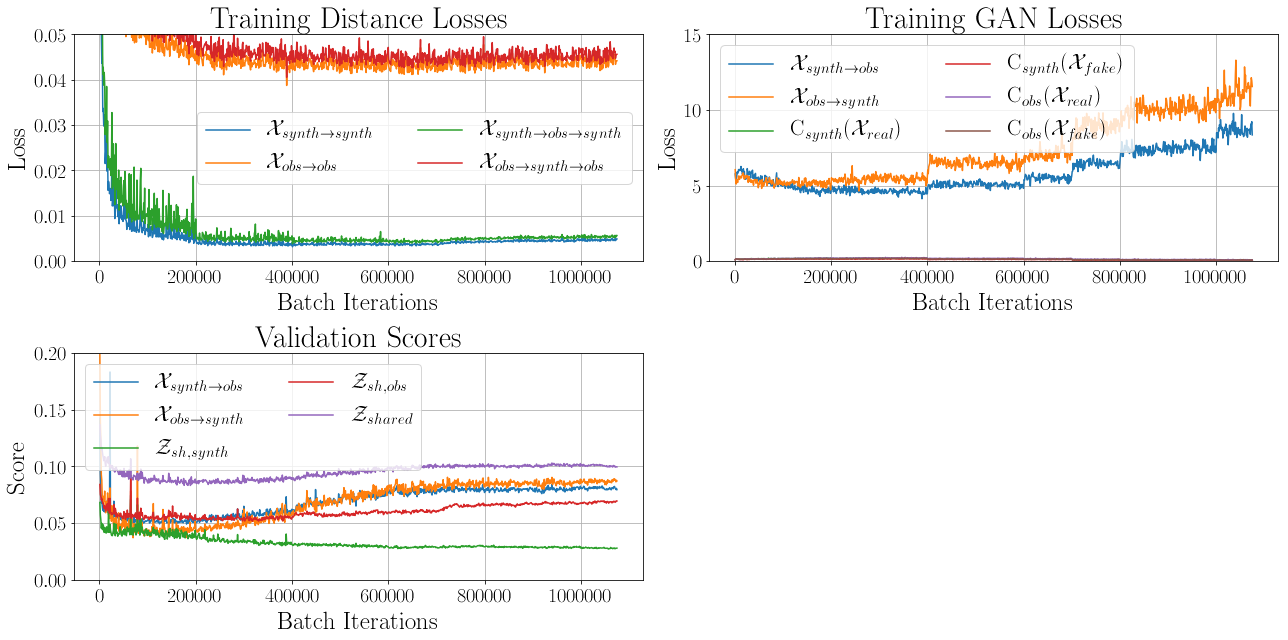

In [41]:
%matplotlib inline
print(model_name)
plot_progress(losses, y_lims=[(0,0.05),(0,15),(0,0.2)], use_split=model.use_split)#, 
              #savename='../figures/'+model_name+'_training_progress.png')

In [42]:
# DATA

# Load ASPCAP wave-grid
wave_grid = apstarwavegrid()

# Normalization data for the spectra
x_mean, x_std = np.load(spectra_norm_file)

# Choose a set of input labels. 

# The order of the labels are:
# Teff, Logg, Vturb [km/s],
# [C/H], [N/H], [O/H], [Na/H], [Mg/H],
# [Al/H], [Si/H], [P/H], [S/H], [K/H],
# [Ca/H], [Ti/H], [V/H], [Cr/H], [Mn/H],
# [Fe/H], [Co/H], [Ni/H], [Cu/H], [Ge/H],
# C12/C13, Vmacro [km/s] 
ref_labels = np.array([[4750., 2.5, 1.5, 0., 0., 0., 0., 0., 0., 0., 0., 0., 
                        0., 0., 0., 0., 0., 0.,0., 0., 0., 0., 0., 7.5, 6.]])
ref_labels = torch.from_numpy(ref_labels.astype(np.float32)) 

def y_to_synth(y):

    # Produce synthetic spectrum
    x = model.emulator(y)
    
    # Return last 7167 pixels
    return x[:,47:]

def y_to_synth_to_synth(y):

    # Produce synthetic spectrum with masked lines
    x = y_to_synth(y)
    
    # Normalize
    x = (x-x_mean)/x_std
    
    # Encode the synthetic spectrum
    z = model.synth_to_z(x)

    # Decode the latent variables into the synthetic domain
    x = model.z_to_synth(z)
    
    # Return to the regular continuum level and scale
    x = x*x_std + x_mean
    
    return x

def y_to_synth_to_obs(y):

    # Produce synthetic spectrum with masked lines
    x = y_to_synth(y)
    
    # Normalize
    x = (x-x_mean)/x_std
    
    # Encode the synthetic spectrum
    z = model.synth_to_z(x)

    # Decode the latent variables into the observed domain
    x = model.z_to_obs(z)
    
    # Return to the regular continuum level and scale
    x = x*x_std + x_mean
    
    return x

 Approximate y->synth and y->synth->synth derivatives

In [43]:
jac_synth  = np.zeros((int(config['ARCHITECTURE']['num_pixels']),25))
jac_synthsynth  = np.zeros((int(config['ARCHITECTURE']['num_pixels']),25))

for ele_index in range(25):

    # Deviate reference labels
    deviate_labels = torch.clone(ref_labels)
    deviate_labels[0,ele_index] += 0.05

    # Scale labels for emulator input
    y = (ref_labels - model.y_min)/(model.y_max-model.y_min) - 0.5
    y_dev = (deviate_labels - model.y_min)/(model.y_max-model.y_min) - 0.5

    # Create a synthetic spectrum
    x_synth = y_to_synth(y).data.numpy()
    x_synth_dev = y_to_synth(y_dev).data.numpy()

    # Reconstruct spectrum
    x_synthsynth = y_to_synth_to_synth(y).data.numpy()
    x_synthsynth_dev = y_to_synth_to_synth(y_dev).data.numpy()

    # Calculate difference
    jac_synth[:,ele_index] = x_synth_dev-x_synth
    jac_synthsynth[:,ele_index] = x_synthsynth_dev-x_synthsynth
    
# Only select abundances
jac_synthsynth = jac_synthsynth[:,3:-2]
jac_synth = jac_synth[:,3:-2]

# Calculate difference
jac_diff = jac_synthsynth - jac_synth    

paynetodr14_nozsplit_53
[Na/H]


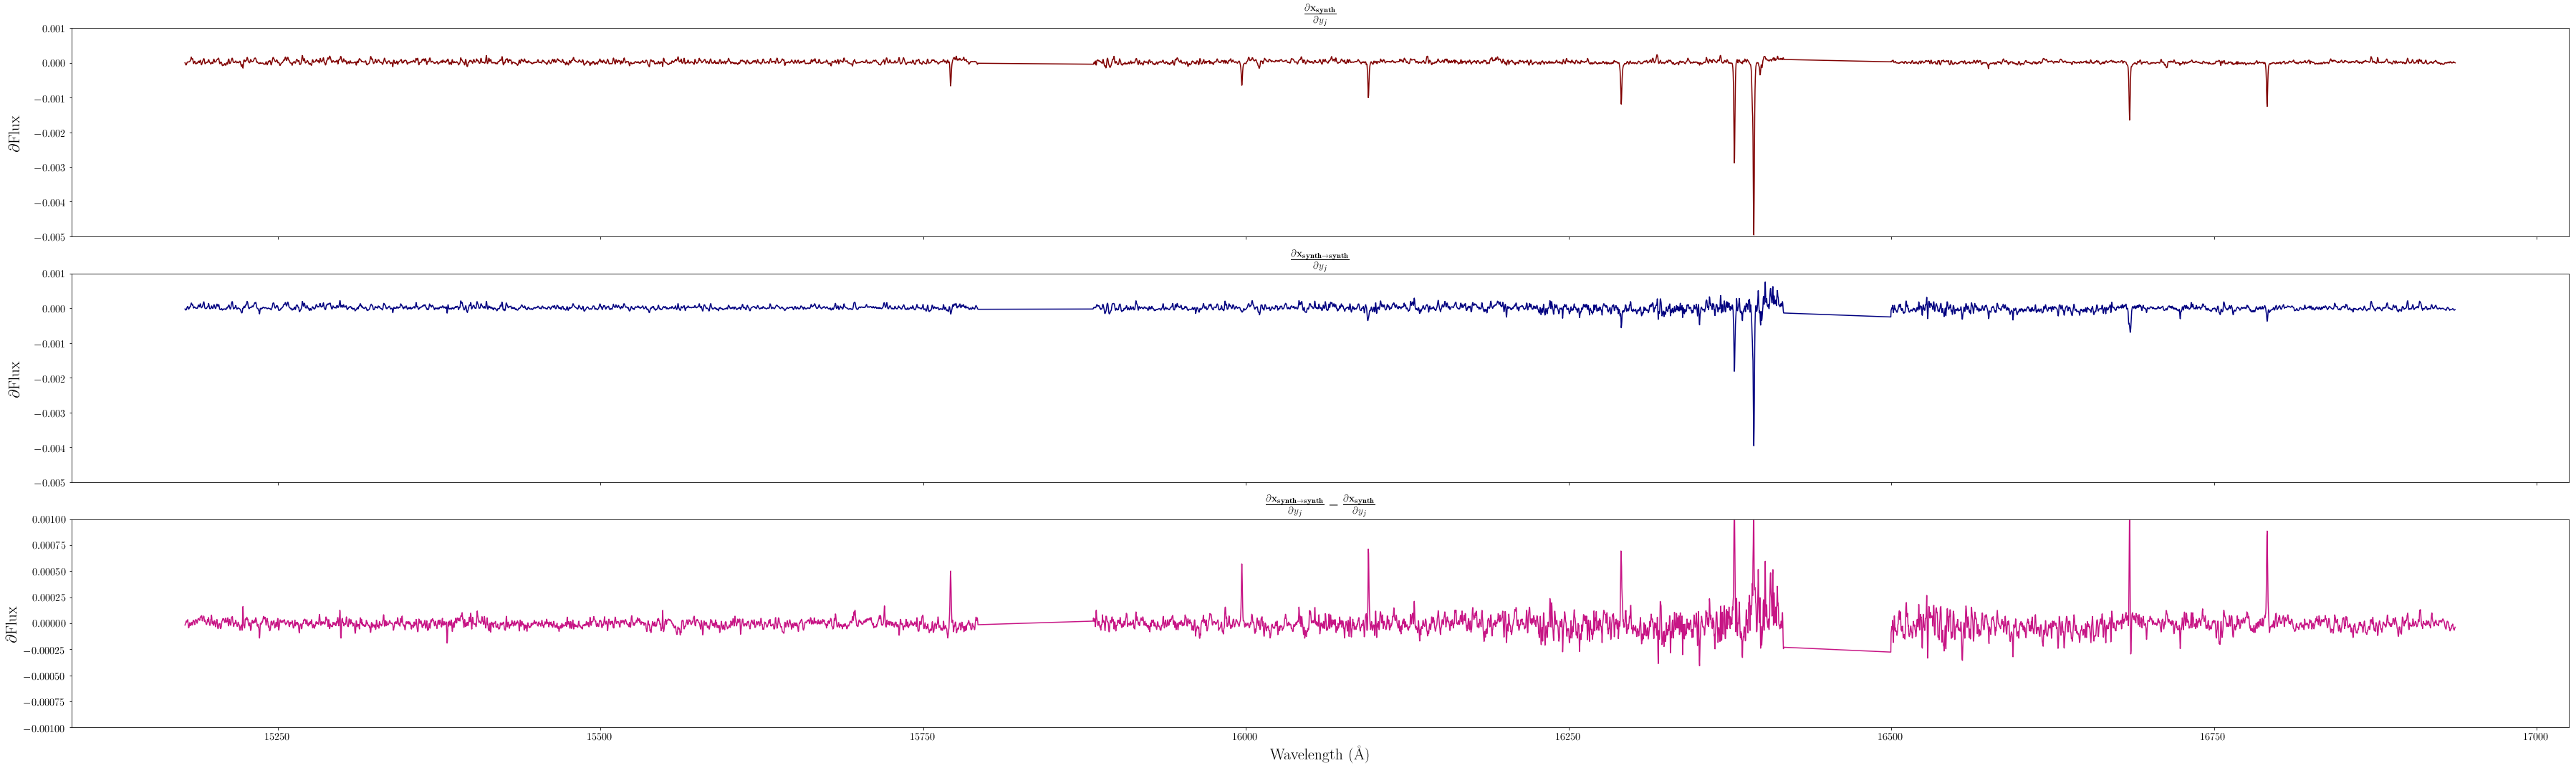

[Mg/H]


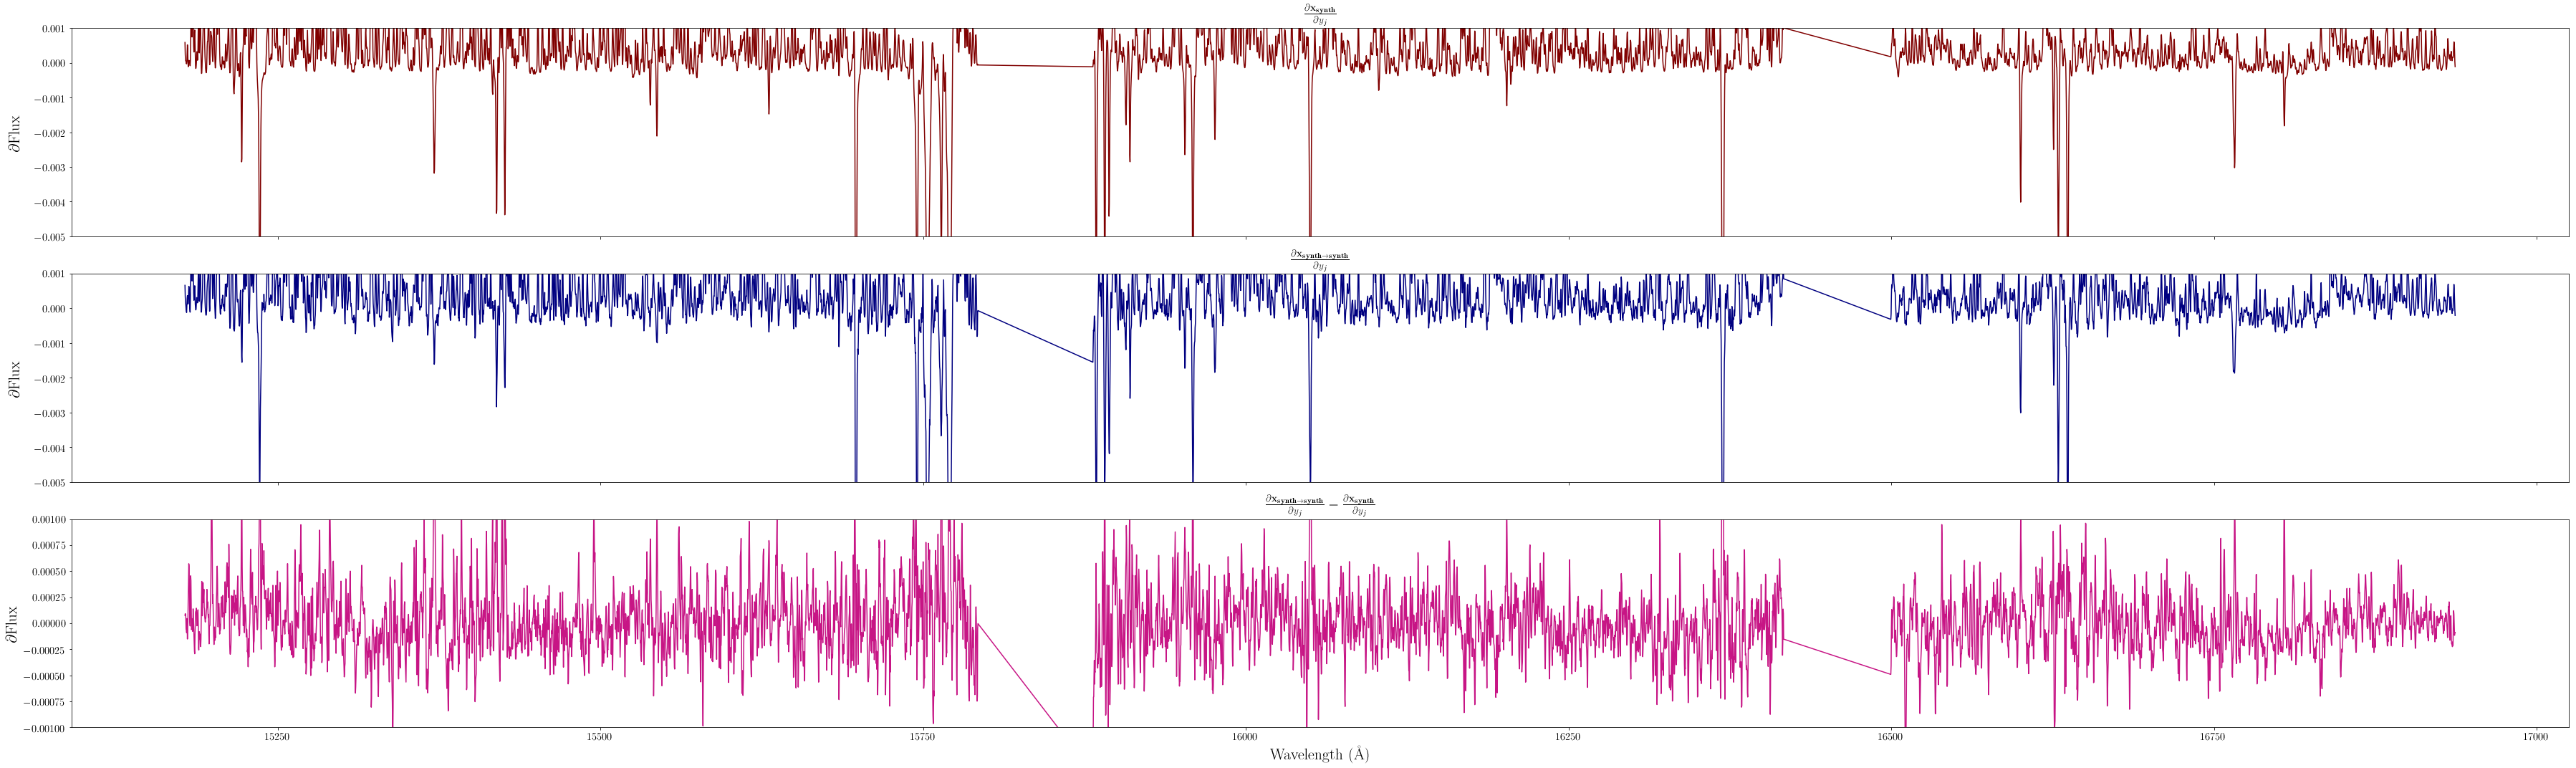

[S/H]


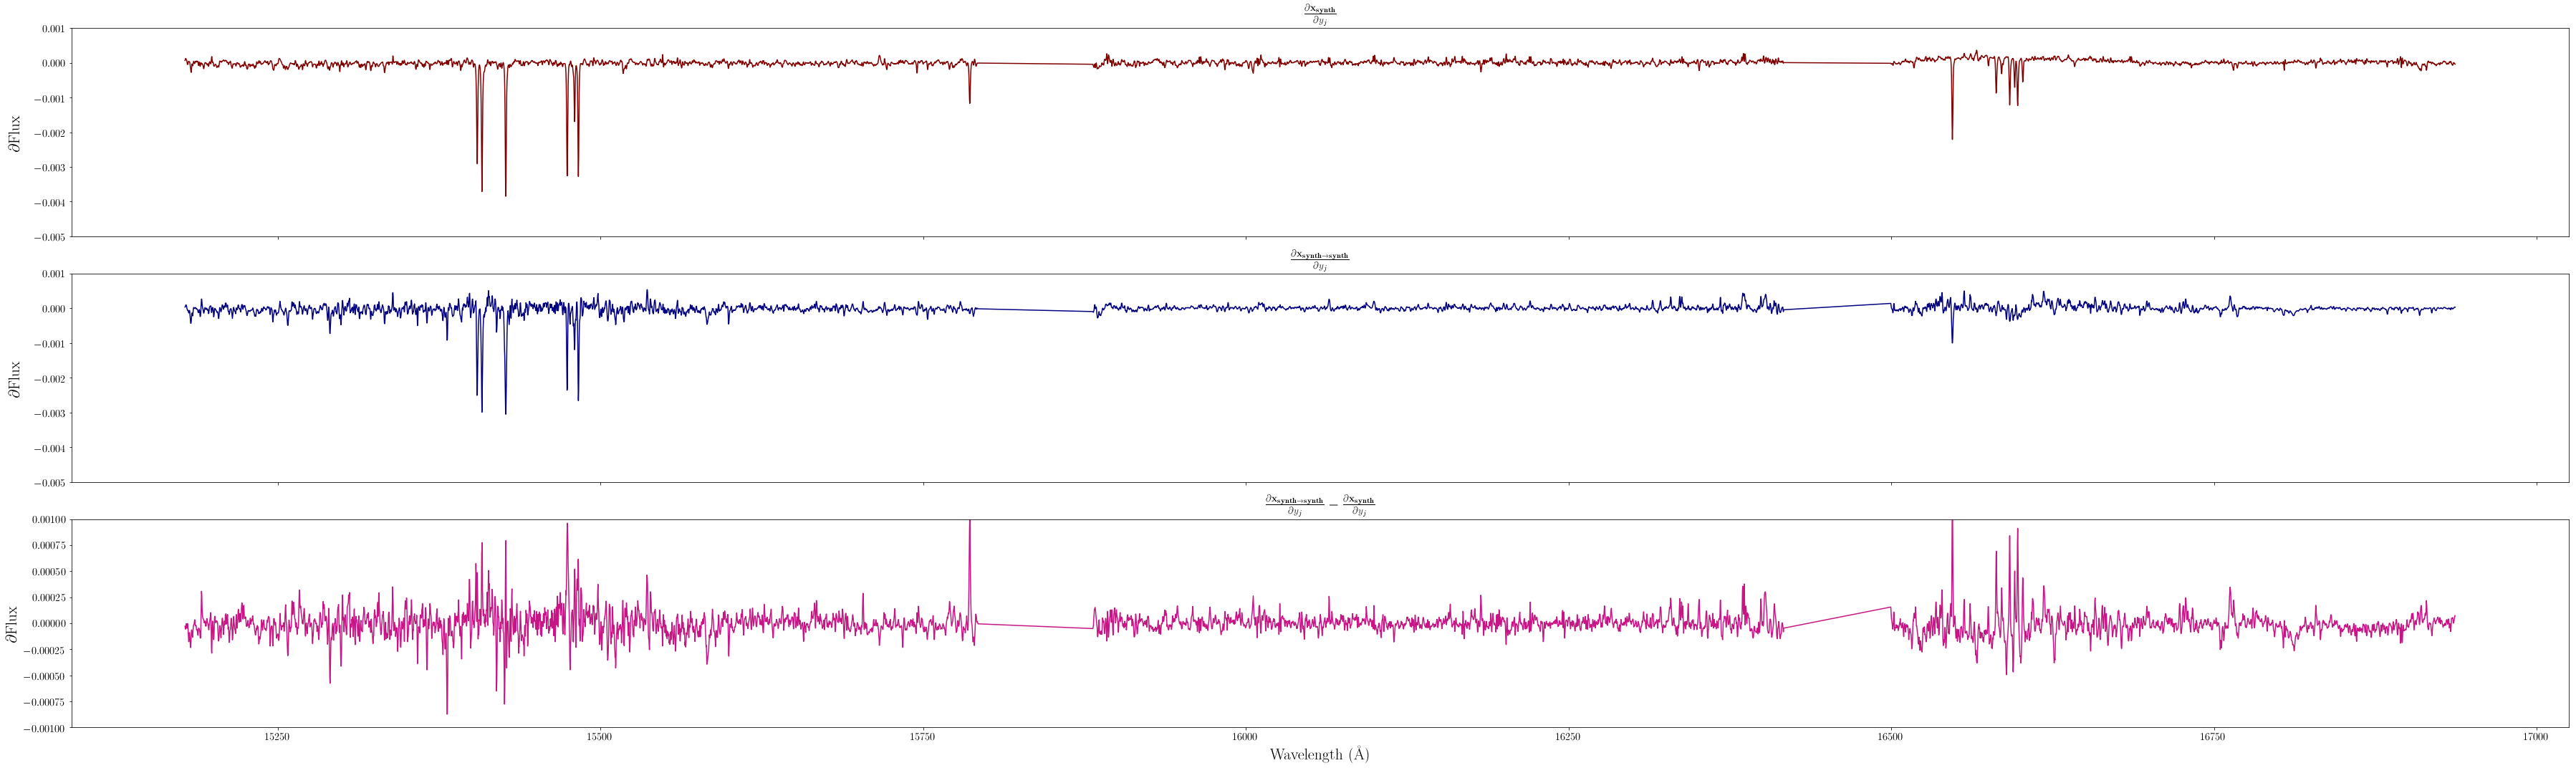

[K/H]


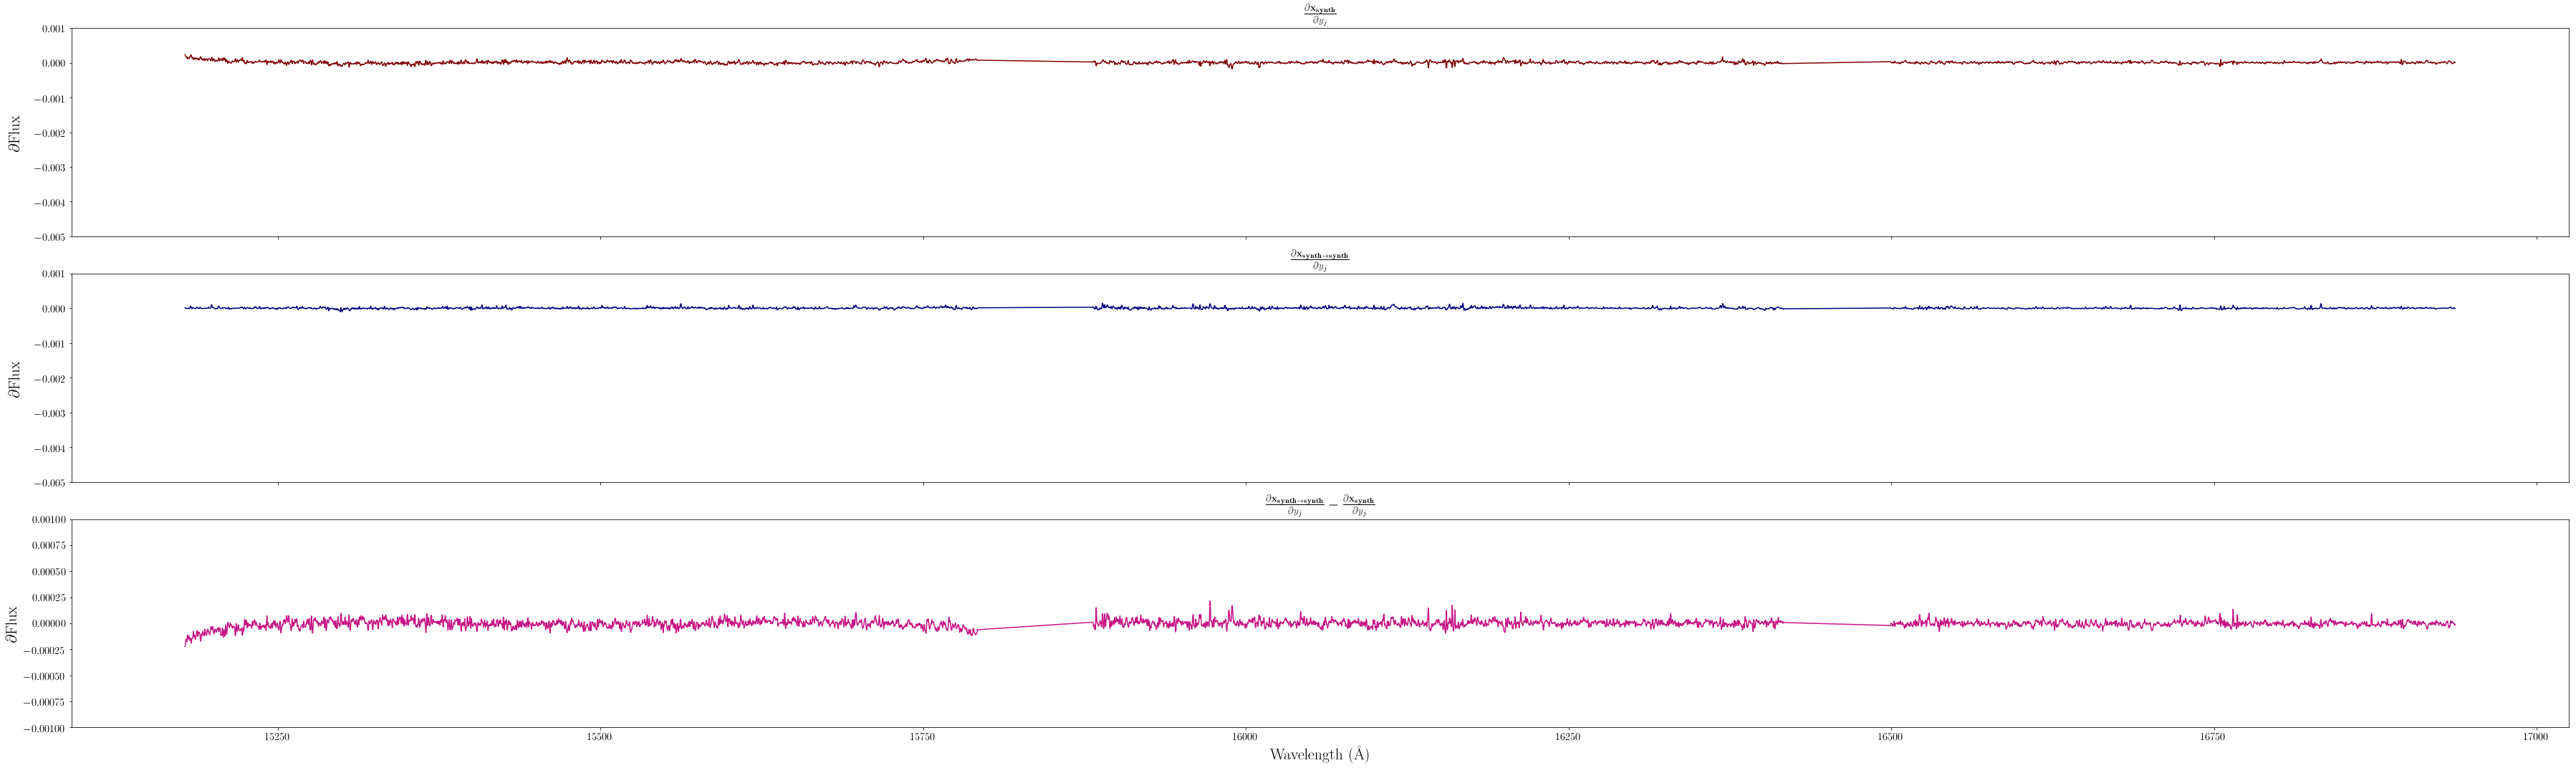

[Cu/H]


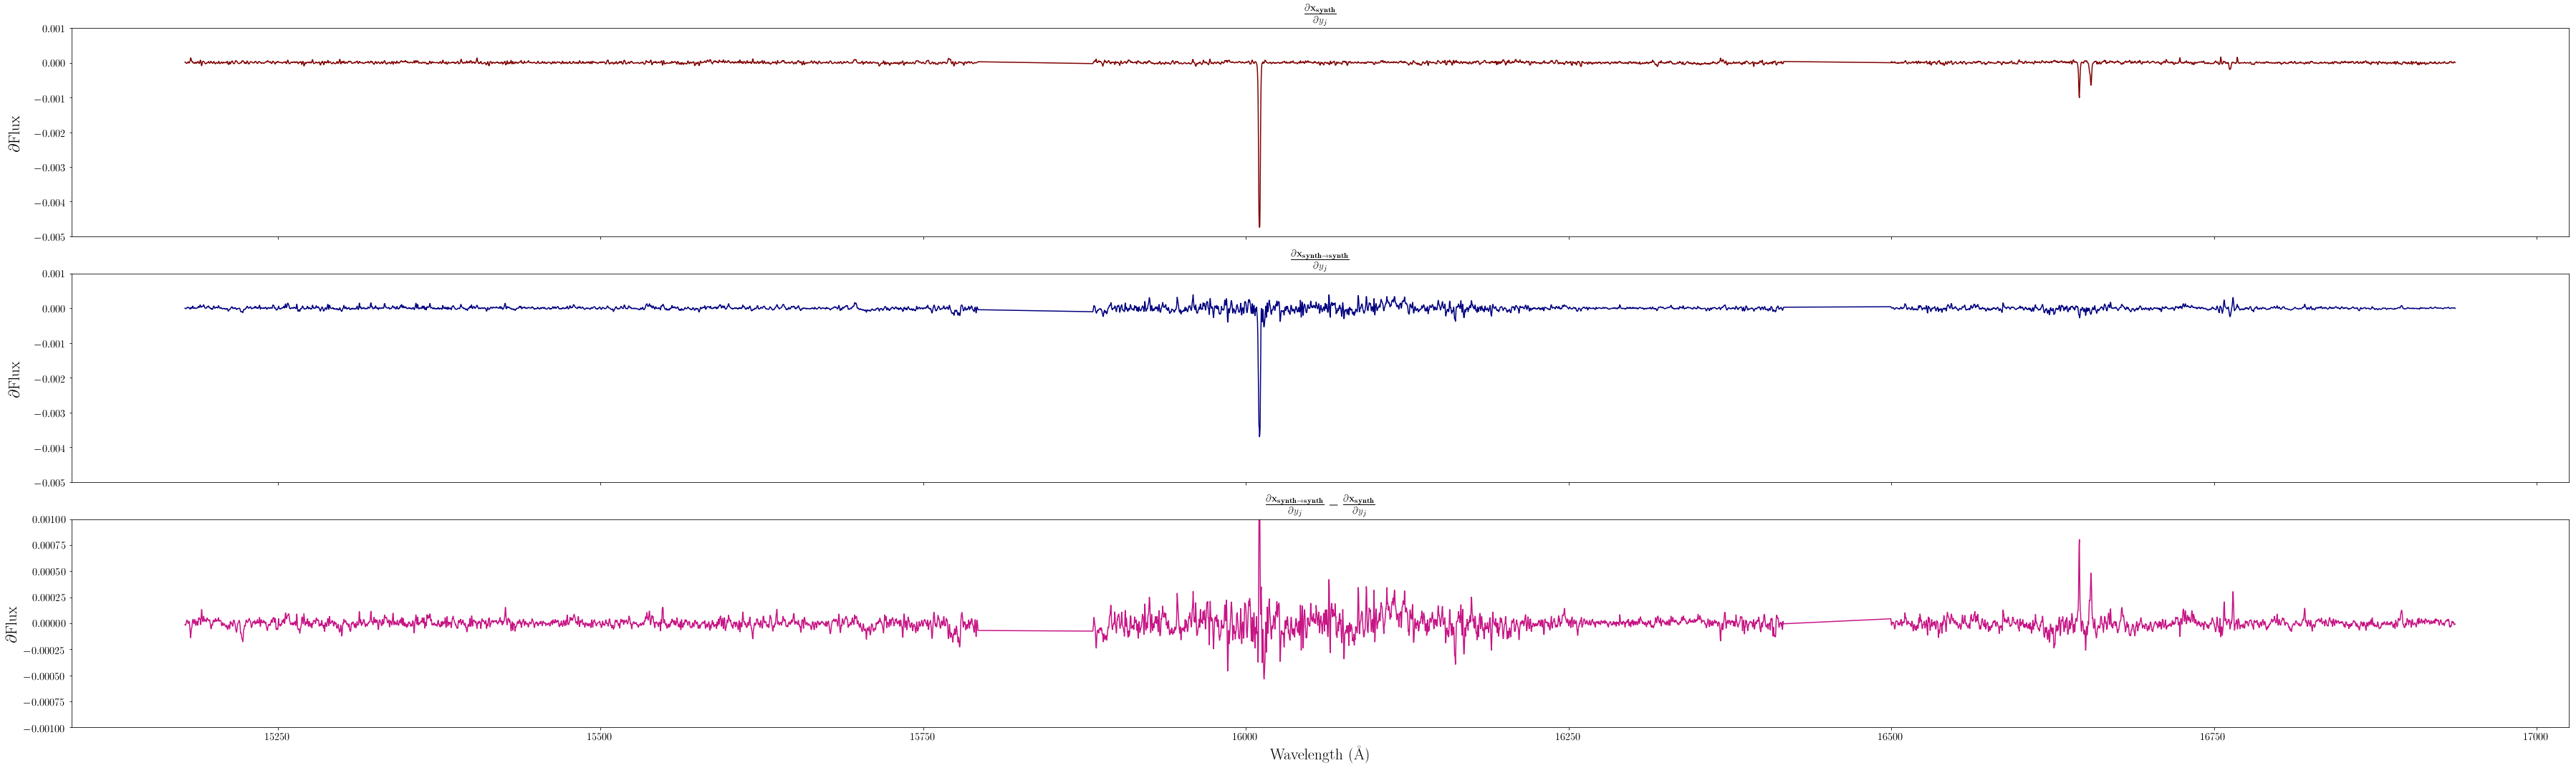

In [44]:
print(model_name)

# Choose an element:
elem_labels = ['[C/H]', '[N/H]', '[O/H]', '[Na/H]', '[Mg/H]',
               '[Al/H]', '[Si/H]', '[P/H]', '[S/H]', '[K/H]',
               '[Ca/H]', '[Ti/H]', '[V/H]', '[Cr/H]', '[Mn/H]',
               '[Fe/H]', '[Co/H]', '[Ni/H]', '[Cu/H]', '[Ge/H]']

#ele_index = 18 # [Cu/H]
ele_index = 3 # [Na/H]
#ele_index = 9 # [K/H]
#ele_index = 8 # [S/H]
#ele_index = 4 # [Mg/H]

for ele_index in [3,4,8,9,18]:

    plt.close('all')
    print(elem_labels[ele_index])
    # Plot test results
    fig, axes = plt.subplots(3,1,figsize=(50,15), sharex=True)
    j_synth, = axes[0].plot(wave_grid[47:], jac_synth[:,ele_index], c='maroon')
    j_obs, = axes[1].plot(wave_grid[47:], jac_synthsynth[:,ele_index], c='navy')
    j_diff, = axes[2].plot(wave_grid[47:], jac_diff[:,ele_index], c='mediumvioletred')

    for i in range(3):
        axes[i].tick_params(labelsize=15)

    axes[0].set_ylim((-0.005,0.001))
    axes[1].set_ylim((-0.005,0.001))
    axes[2].set_ylim((-0.001,0.001))

    axes[0].set_ylabel(r'$\partial$Flux',fontsize=22,labelpad=15)
    axes[1].set_ylabel(r'$\partial$Flux',fontsize=22,labelpad=15)
    axes[2].set_ylabel(r'$\partial$Flux',fontsize=22)
    plt.xlabel(r'Wavelength (\AA)',fontsize=22)

    axes[0].set_title(r'$\frac{\partial{\mathbf{x_{synth}}}}{\partial{y_j}}$', fontsize=20)
    axes[1].set_title(r'$\frac{\partial{\mathbf{x_{synth \rightarrow synth}}}}{\partial{y_j}}$', fontsize=20)
    axes[2].set_title(r'$\frac{\partial{\mathbf{x_{synth \rightarrow synth}}}}{\partial{y_j}}-\frac{\partial{\mathbf{x_{synth}}}}{\partial{y_j}}$', fontsize=20)

    plt.tight_layout()    
    plt.show()

Now do the same for the y->synth->obs domain.

In [45]:
jac_synth  = np.zeros((int(config['ARCHITECTURE']['num_pixels']),25))
jac_synthobs  = np.zeros((int(config['ARCHITECTURE']['num_pixels']),25))

for ele_index in range(25):

    # Deviate reference labels
    deviate_labels = torch.clone(ref_labels)
    deviate_labels[0,ele_index] += 0.05

    # Scale labels for emulator input
    y = (ref_labels - model.y_min)/(model.y_max-model.y_min) - 0.5
    y_dev = (deviate_labels - model.y_min)/(model.y_max-model.y_min) - 0.5

    # Create a synthetic spectrum
    x_synth = y_to_synth(y).data.numpy()
    x_synth_dev = y_to_synth(y_dev).data.numpy()

    # Create observed spectrum
    x_synthobs = y_to_synth_to_obs(y).data.numpy()
    x_synthobs_dev = y_to_synth_to_obs(y_dev).data.numpy()

    # Calculate difference
    jac_synth[:,ele_index] = x_synth_dev-x_synth
    jac_synthobs[:,ele_index] = x_synthobs_dev-x_synthobs
    
# Only select abundances
jac_synthobs = jac_synthobs[:,3:-2]
jac_synth = jac_synth[:,3:-2]

# Calculate difference
jac_diff = jac_synthobs - jac_synth    

paynetodr14_nozsplit_53
[Na/H]


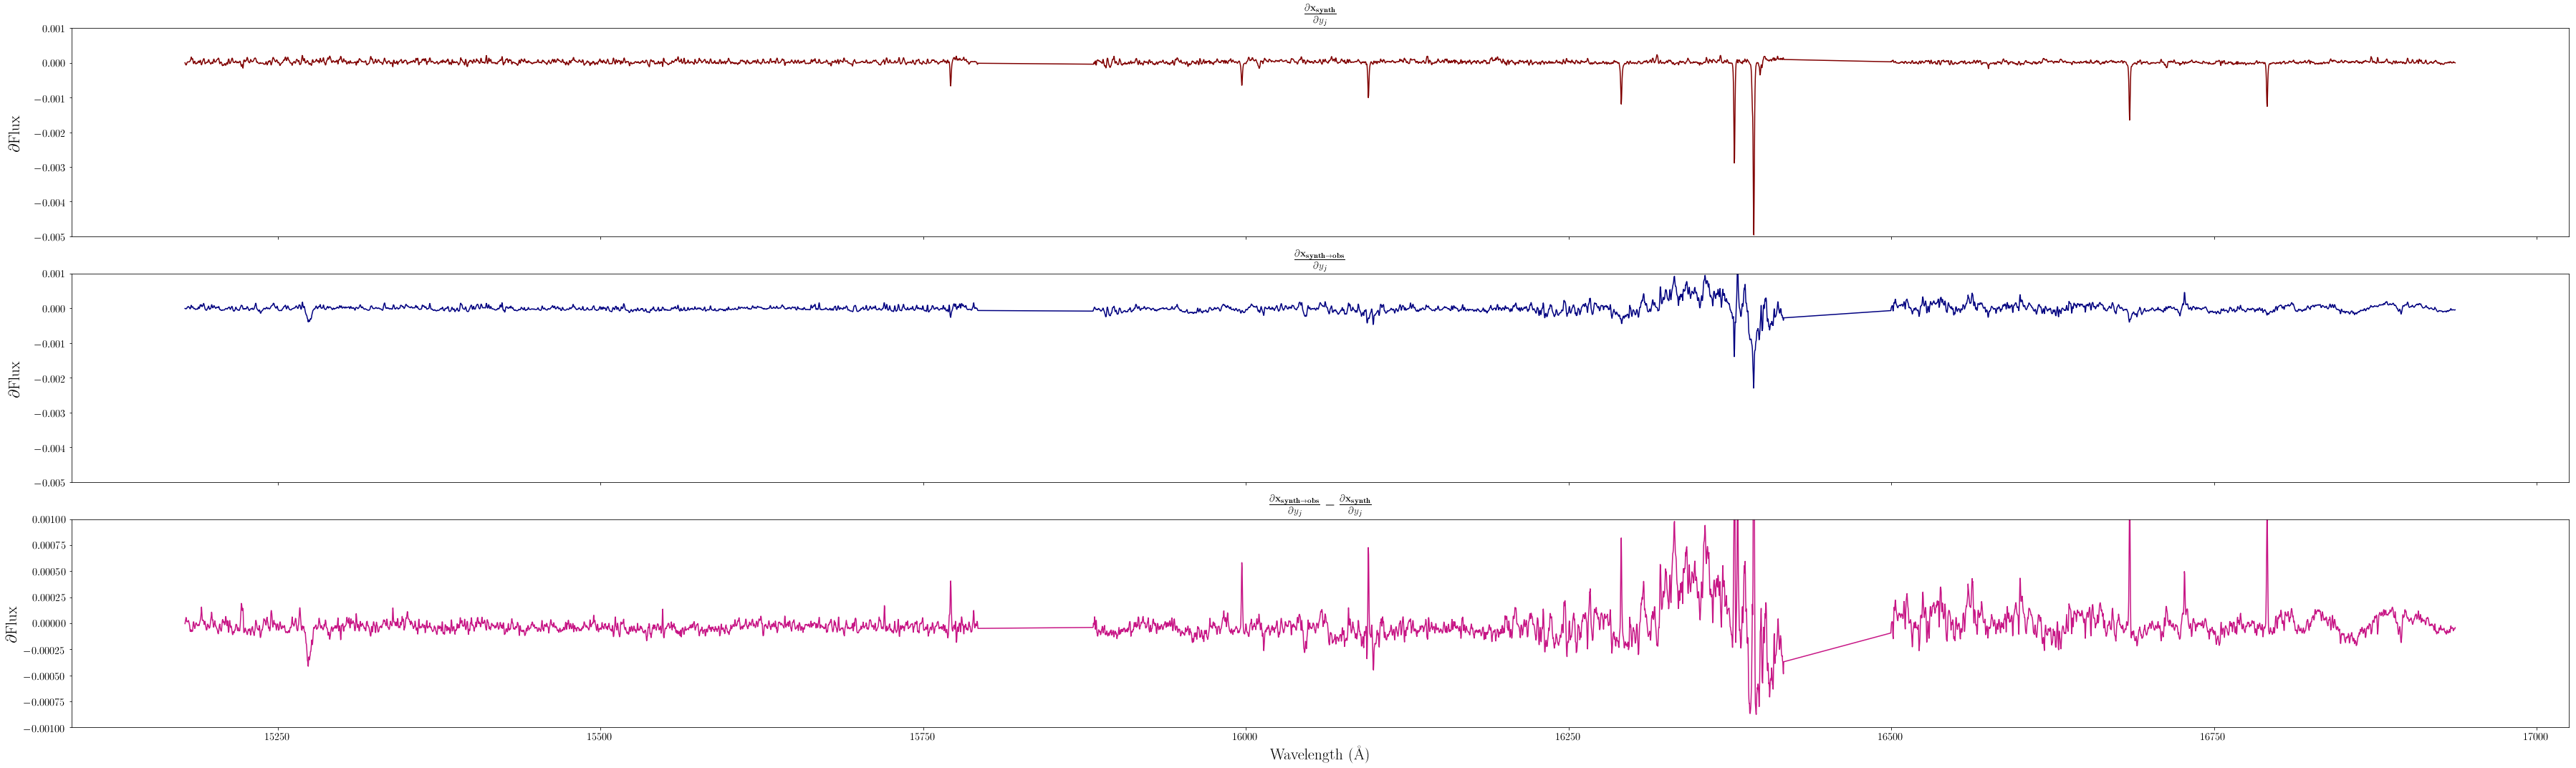

[Mg/H]


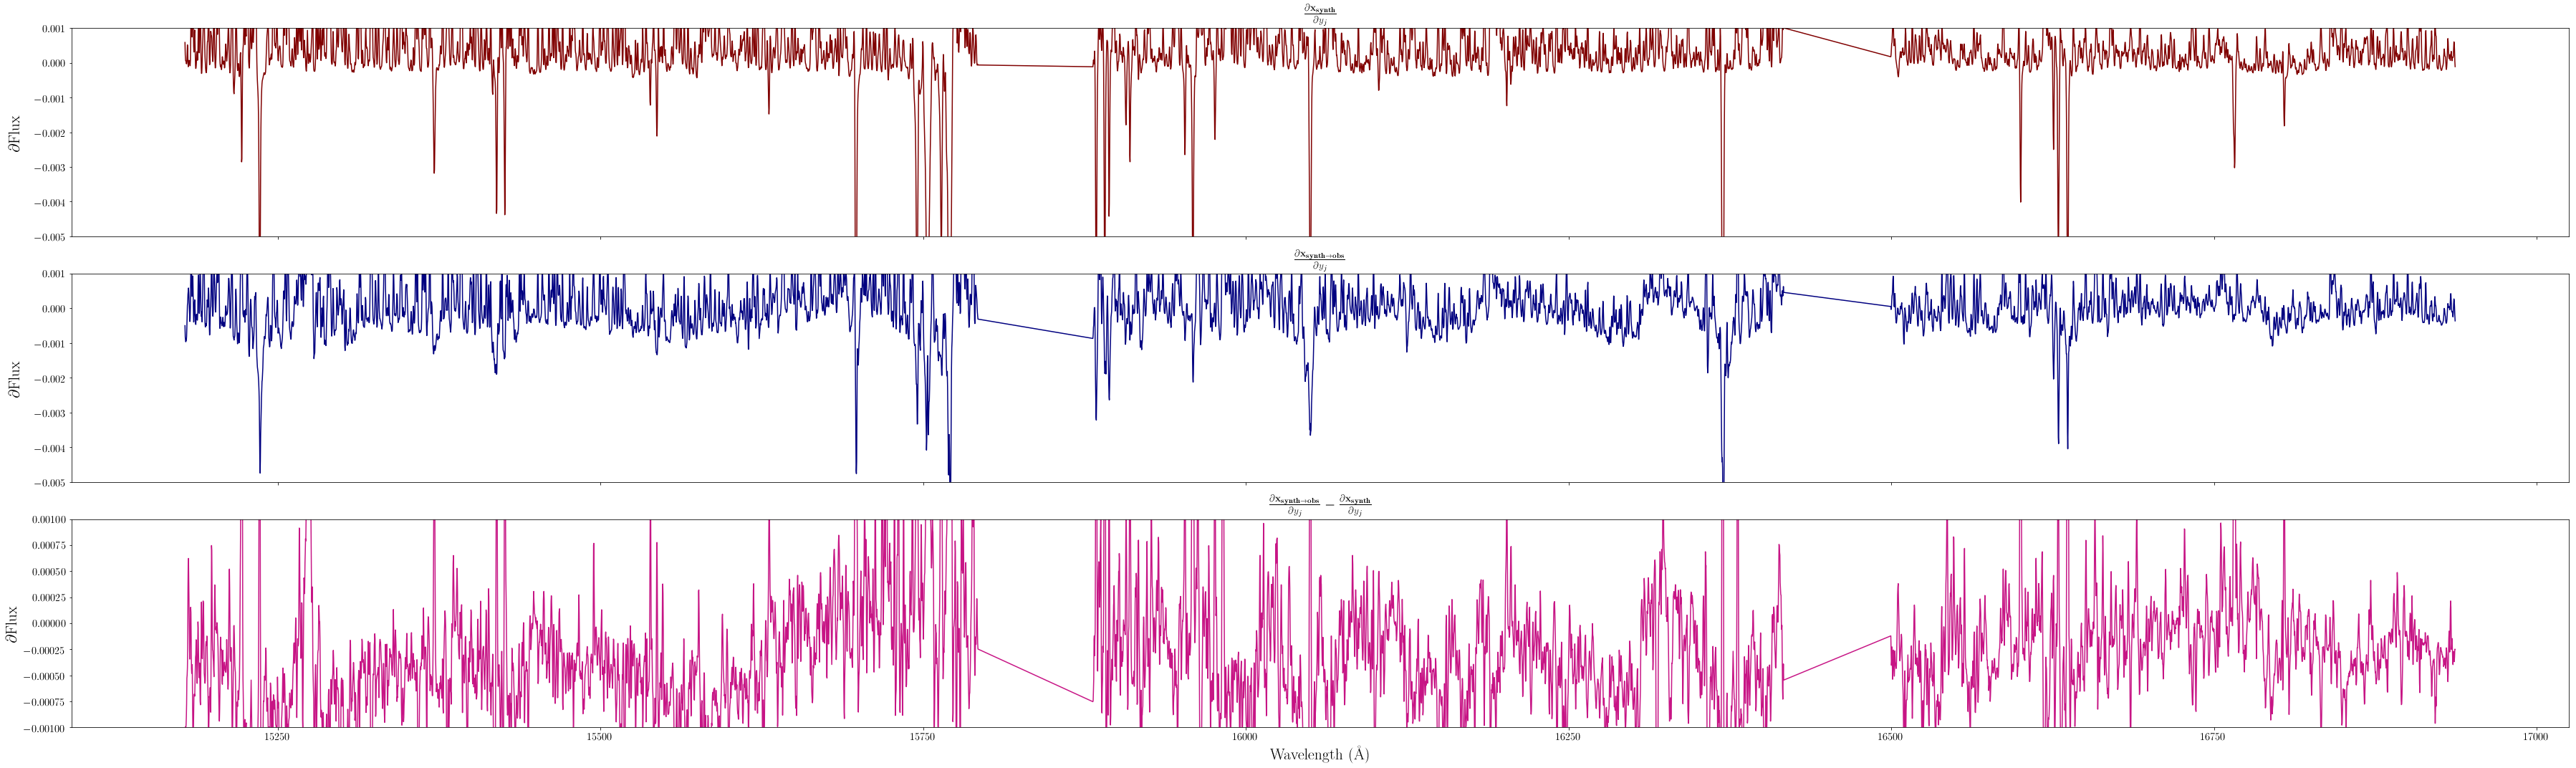

[S/H]


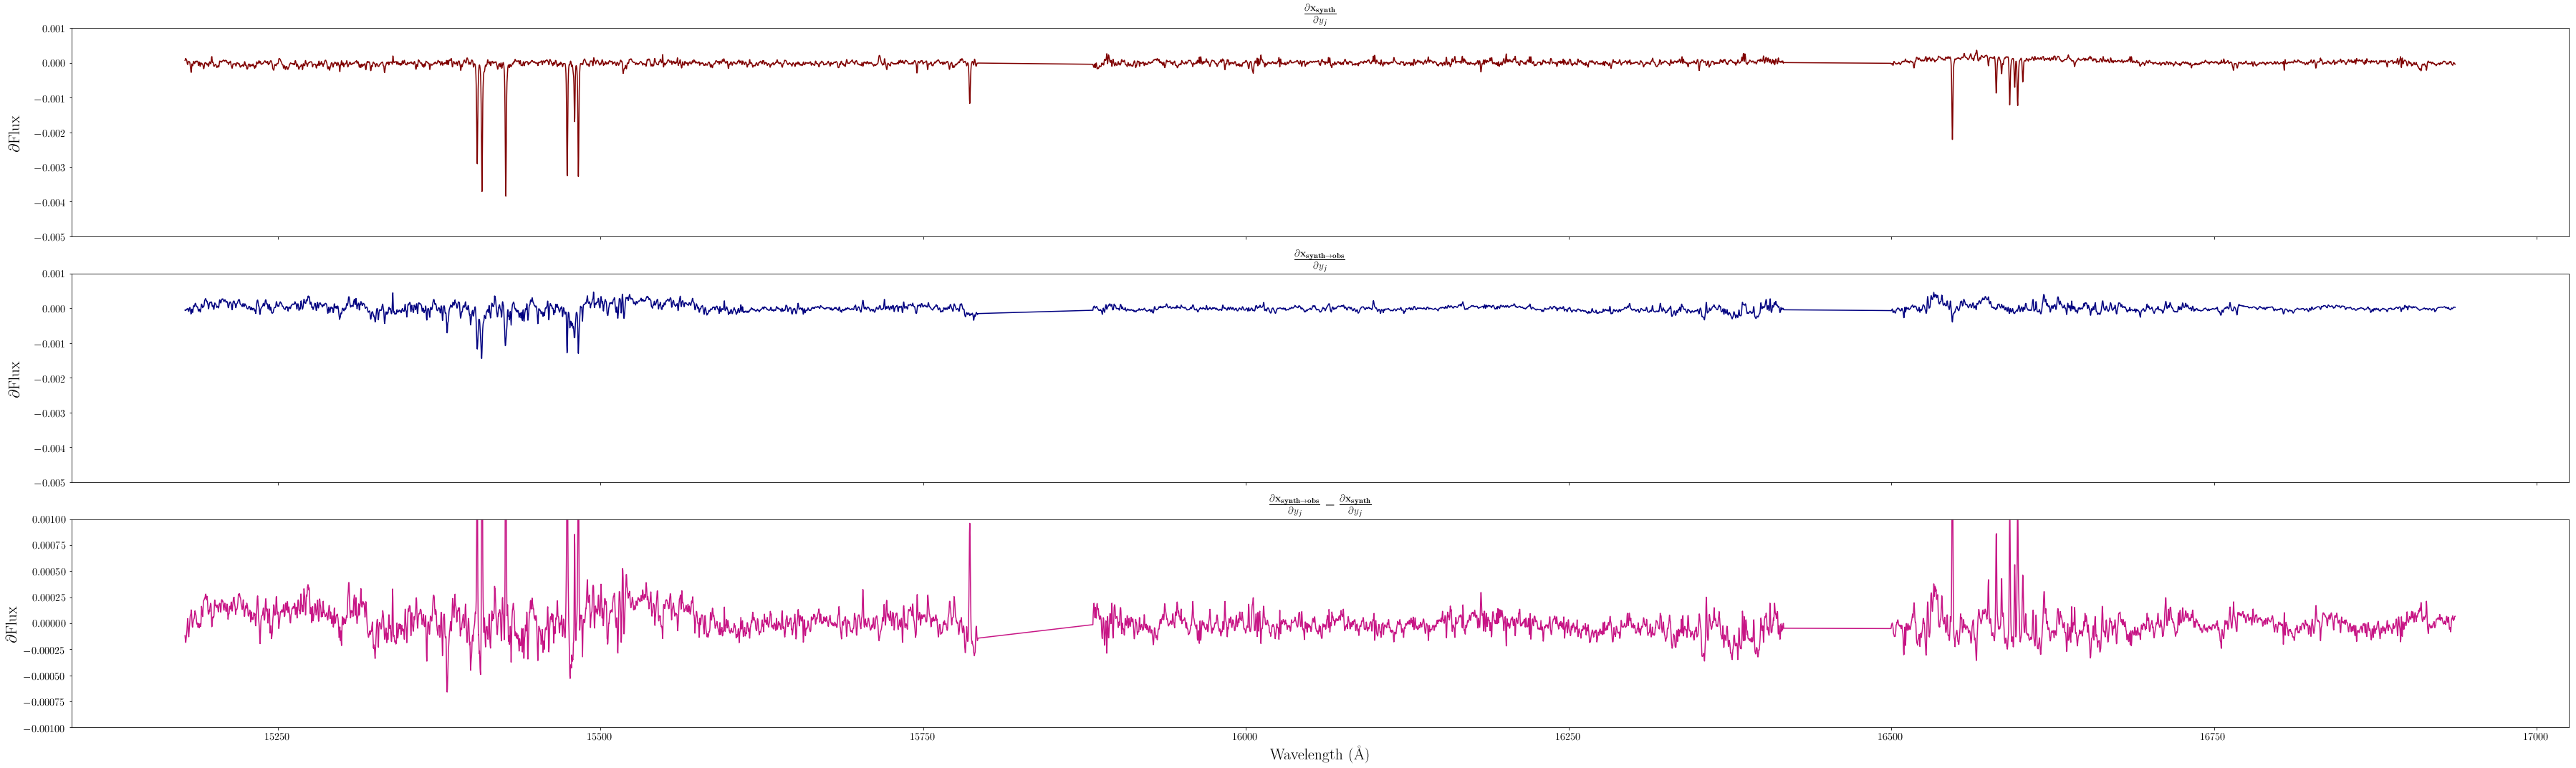

[K/H]


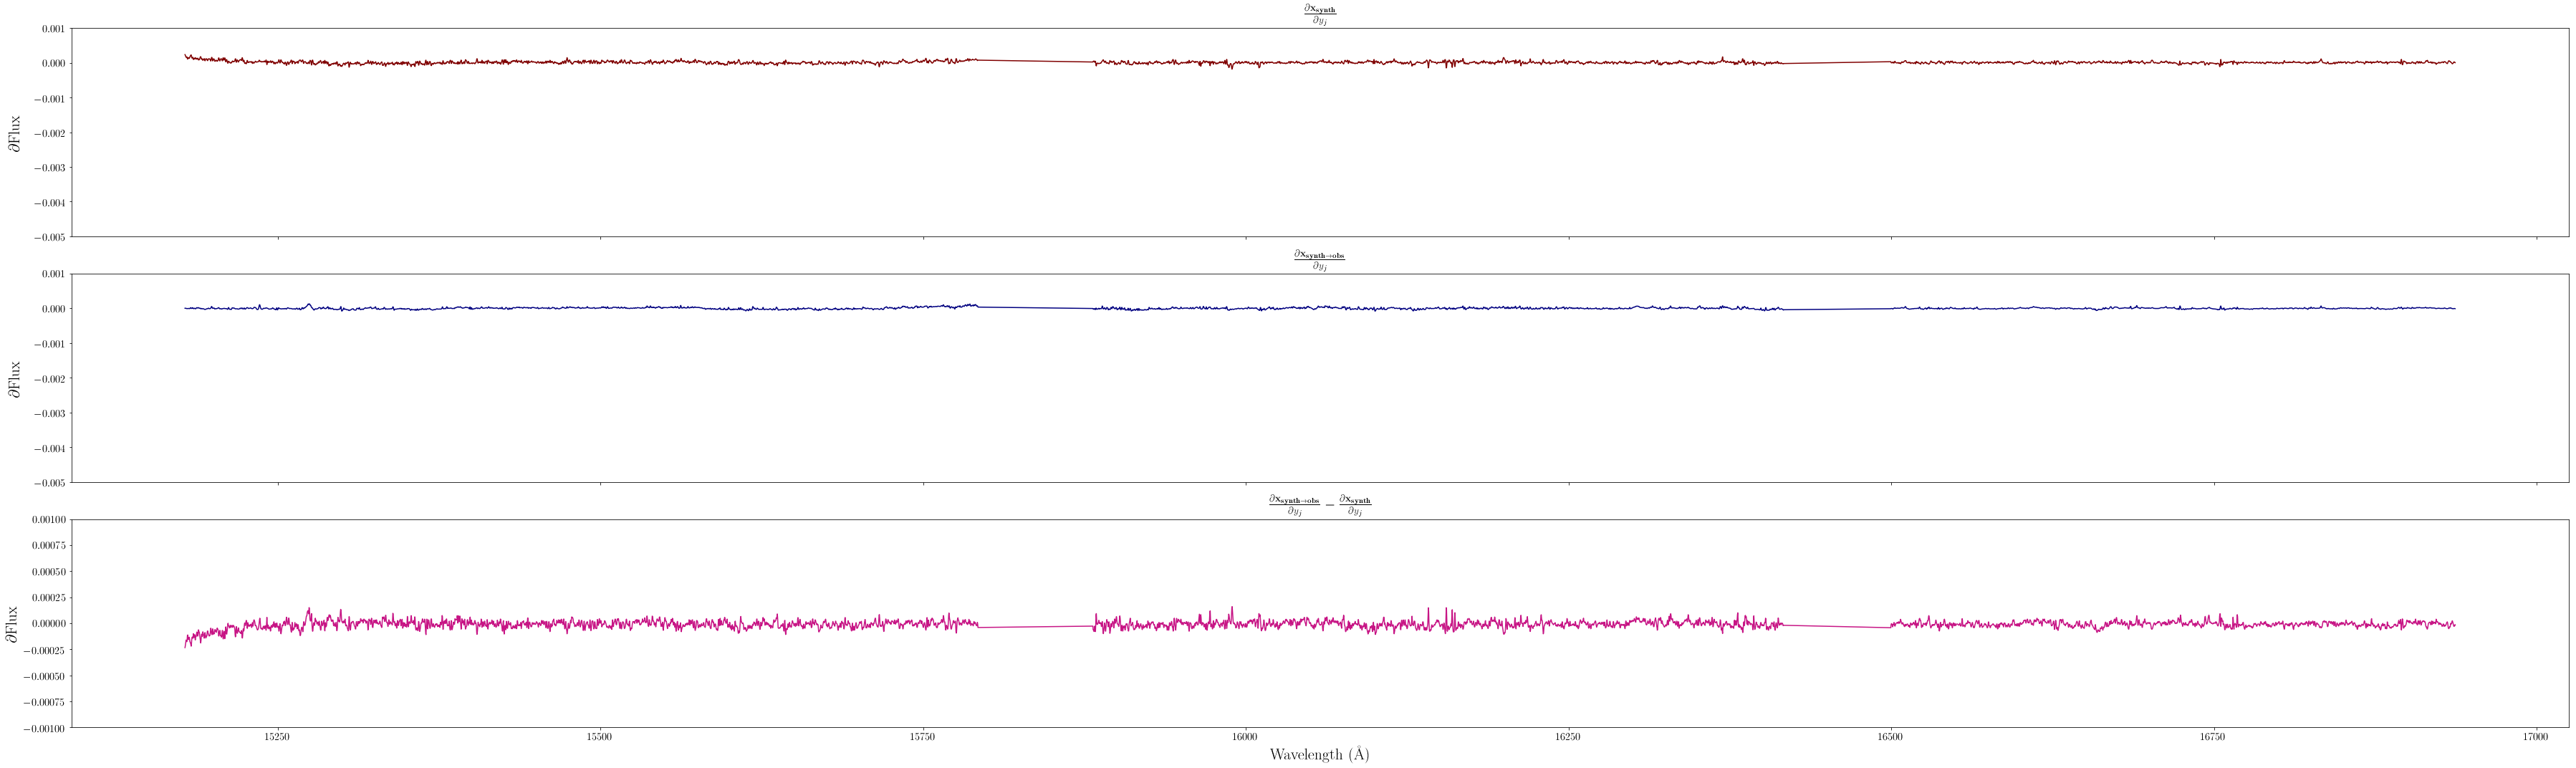

[Cu/H]


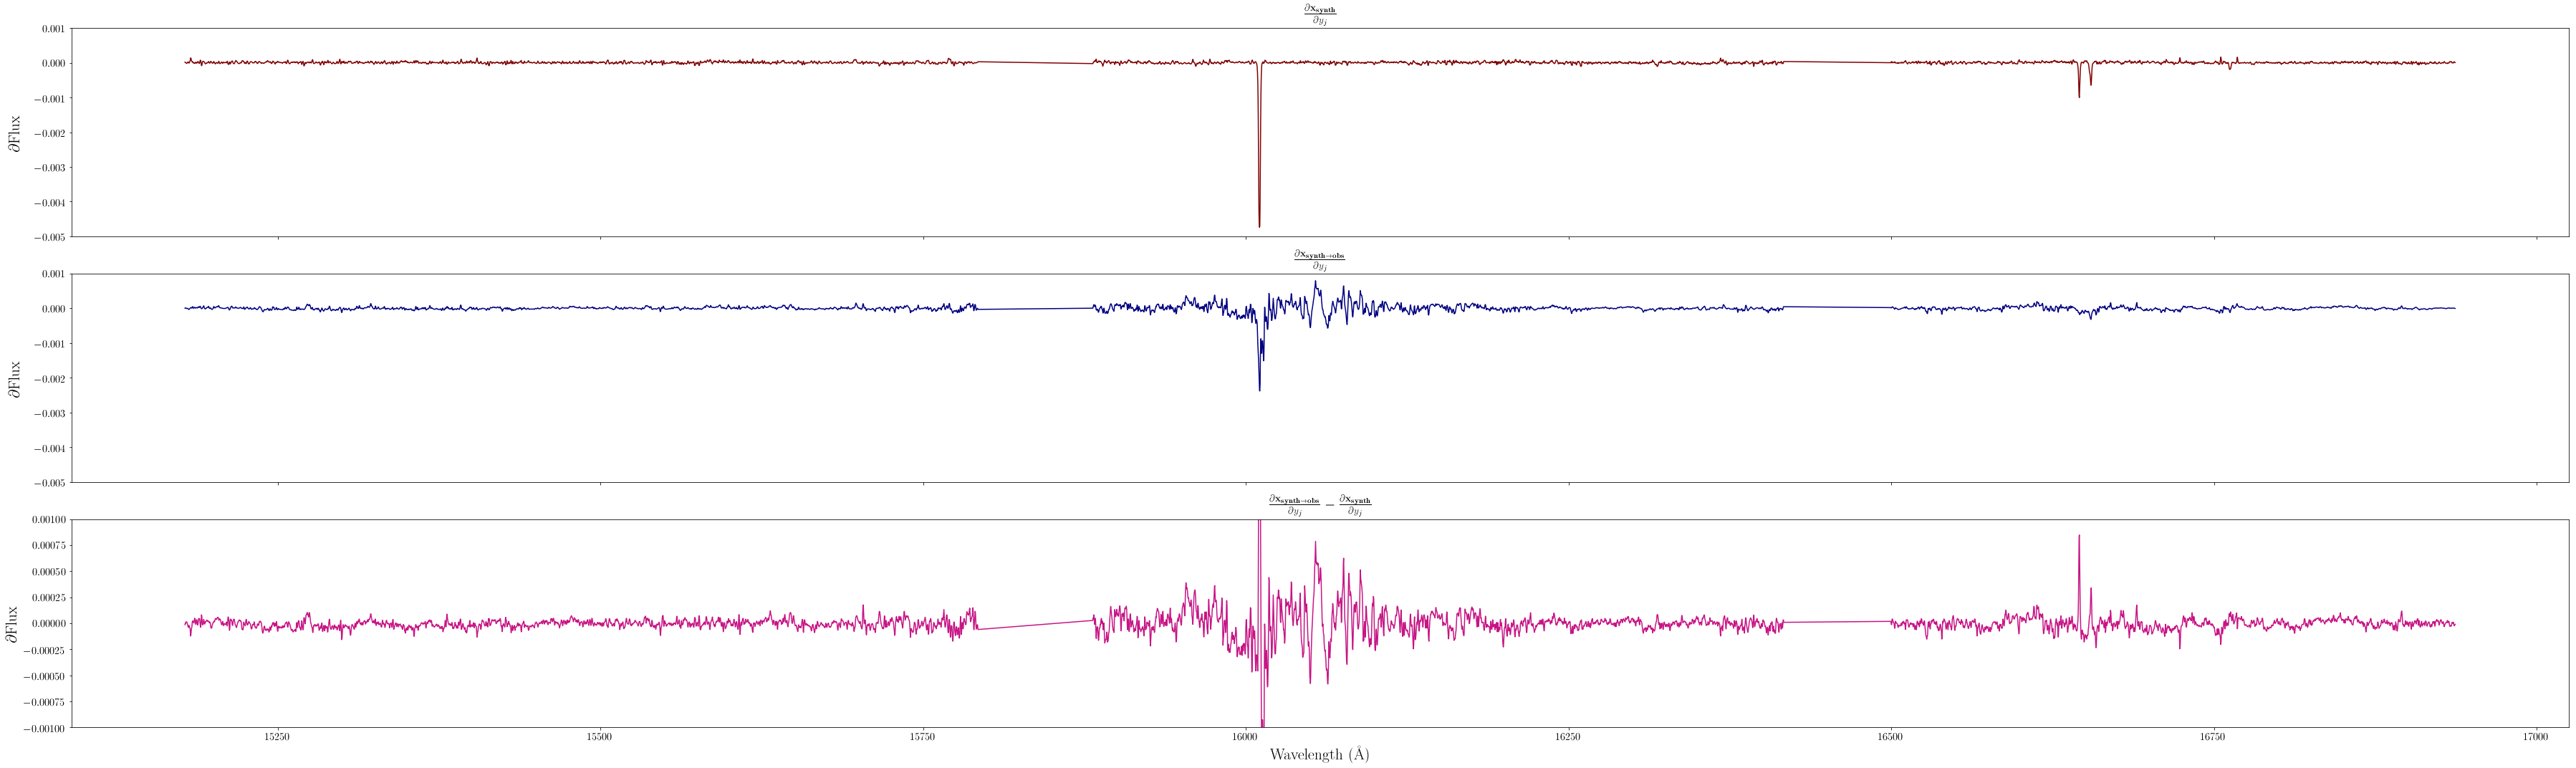

In [46]:
print(model_name)

# Choose an element:
elem_labels = ['[C/H]', '[N/H]', '[O/H]', '[Na/H]', '[Mg/H]',
               '[Al/H]', '[Si/H]', '[P/H]', '[S/H]', '[K/H]',
               '[Ca/H]', '[Ti/H]', '[V/H]', '[Cr/H]', '[Mn/H]',
               '[Fe/H]', '[Co/H]', '[Ni/H]', '[Cu/H]', '[Ge/H]']

#ele_index = 18 # [Cu/H]
ele_index = 3 # [Na/H]
#ele_index = 9 # [K/H]
#ele_index = 8 # [S/H]
#ele_index = 4 # [Mg/H]

for ele_index in [3,4,8,9,18]:

    plt.close('all')
    print(elem_labels[ele_index])
    # Plot test results
    fig, axes = plt.subplots(3,1,figsize=(50,15), sharex=True)
    j_synth, = axes[0].plot(wave_grid[47:], jac_synth[:,ele_index], c='maroon')
    j_obs, = axes[1].plot(wave_grid[47:], jac_synthobs[:,ele_index], c='navy')
    j_diff, = axes[2].plot(wave_grid[47:], jac_diff[:,ele_index], c='mediumvioletred')

    for i in range(3):
        axes[i].tick_params(labelsize=15)

    axes[0].set_ylim((-0.005,0.001))
    axes[1].set_ylim((-0.005,0.001))
    axes[2].set_ylim((-0.001,0.001))

    axes[0].set_ylabel(r'$\partial$Flux',fontsize=22,labelpad=15)
    axes[1].set_ylabel(r'$\partial$Flux',fontsize=22,labelpad=15)
    axes[2].set_ylabel(r'$\partial$Flux',fontsize=22)
    plt.xlabel(r'Wavelength (\AA)',fontsize=22)

    axes[0].set_title(r'$\frac{\partial{\mathbf{x_{synth}}}}{\partial{y_j}}$', fontsize=20)
    axes[1].set_title(r'$\frac{\partial{\mathbf{x_{synth \rightarrow obs}}}}{\partial{y_j}}$', fontsize=20)
    axes[2].set_title(r'$\frac{\partial{\mathbf{x_{synth \rightarrow obs}}}}{\partial{y_j}}-\frac{\partial{\mathbf{x_{synth}}}}{\partial{y_j}}$', fontsize=20)

    plt.tight_layout()    
    plt.show()